In [1]:
#!pip install yellowbrick
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Sklearn clustering and encoding 
from sklearn.preprocessing import LabelEncoder


import cv2
from sklearn.manifold import TSNE
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Num GPUs Available:  0


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.26.3
seaborn - 0.12.2
nltk - 3.8.1
tensorflow - 2.12.0
cv2 - 4.8.1
gensim - 4.3.0


In [3]:
df=  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
584,8748b6cd9f03afc539f246c55e230502,2016-01-07 05:50:25 +0000,http://www.flipkart.com/fastrack-9912pp09-tees...,Fastrack 9912PP09 Tees Analog Watch - For Men...,"[""Watches >> Wrist Watches >> Fastrack Wrist W...",WATD9H76H9EHPBUF,750.0,750.0,8748b6cd9f03afc539f246c55e230502.jpg,True,Fastrack 9912PP09 Tees Analog Watch - For Men...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Diameter"",..."
515,9823c07cc256788556e424307f5ae9b6,2016-01-07 05:50:25 +0000,http://www.flipkart.com/noise-nosww032-m-famou...,Noise NOSWW032 I M Famous Analog Watch - For ...,"[""Watches >> Wrist Watches >> Noise Wrist Watc...",WATDJYPXSKYGWPXF,999.0,999.0,9823c07cc256788556e424307f5ae9b6.jpg,True,Noise NOSWW032 I M Famous Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
414,2d4f1232af970bd19881ceacad6ccfe3,2015-12-01 06:13:00 +0000,http://www.flipkart.com/playboy-london-new-yor...,Playboy London And New York Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE4BQXSBKGWBE3,398.0,388.0,2d4f1232af970bd19881ceacad6ccfe3.jpg,False,Flipkart.com: Buy Playboy London And New York ...,4,4,NaN,"{""product_specification""=>[{""key""=>""Gift Set C..."
500,6776795cc4521a0cb0d54059649f7d72,2016-01-07 05:50:25 +0000,http://www.flipkart.com/nexus-nx-7668-analog-w...,Nexus NX_7668 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Nexus Wrist Watc...",WATDXFGTFHHKPBNV,999.0,999.0,6776795cc4521a0cb0d54059649f7d72.jpg,True,Nexus NX_7668 Analog Watch - For Men - Buy Ne...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
461,3b80ac036843b278083fabfd9a3c84ff,2016-03-22 19:59:16 +0000,http://www.flipkart.com/vatika-advance-standar...,vatika Advance Standard Idli Maker,"[""Kitchen & Dining >> Cookware >> Steamers & I...",IDMEHY86YP4NFZUG,1999.0,999.0,3b80ac036843b278083fabfd9a3c84ff.jpg,False,Key Features of vatika Advance Standard Idli M...,No rating available,No rating available,vatika,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [6]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [7]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

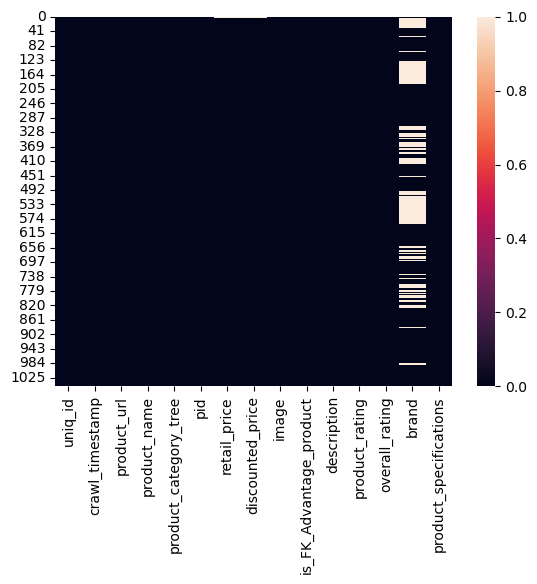

In [8]:
sns.heatmap(df.isnull());

### Traitement de la fonctionnalité "product_category_tree"

In [9]:
df.duplicated(subset="product_category_tree").sum()

408

In [10]:
df_cat = df.groupby('product_category_tree')
df_cat.first()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
product_category_tree,,,,,,,,,,,,,,
"[""Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol...""]",6325bf868b9040a0599f257aba42e9e0,2016-03-03 11:29:08 +0000,http://www.flipkart.com/doraemon-gift-family-c...,Doraemon Gift Family Ceramic Coffee Mug Multic...,DECEG7K7Y3URGWXH,399.0,280.0,6325bf868b9040a0599f257aba42e9e0.jpg,False,Specifications of Doraemon Gift Family Ceramic...,No rating available,No rating available,Doraemon Gift Family Ceramic Coffee Mug,"{""product_specification""=>[{""key""=>""Sales Pack..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames""]",fd10586bf7f01bc57e0c5364d4b2c3f7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/cocovey-metal-photo-fr...,Cocovey Metal Photo Frame,PHFEBZ2GBSK3U43Z,749.0,549.0,fd10586bf7f01bc57e0c5364d4b2c3f7.jpg,False,"Cocovey Metal Photo Frame (Photo Size - 6*4, 1...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames""]",6eabdbbbffdfae86c3c5177ba0f96ea7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/indha-craft-cloth-phot...,Indha Craft Cloth Photo Frame,PHFDWUHW25WAWXHY,300.0,132.0,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,False,Indha Craft Cloth Photo Frame (Photo Size - 12...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> MH Photo Frames""]",d06bb04b096c77dc3302eaf2db336f96,2015-12-31 09:19:31 +0000,http://www.flipkart.com/mh-mdf-photo-frame/p/i...,MH MDF Photo Frame,PHFEE9ZQGBXX5NYY,999.0,899.0,d06bb04b096c77dc3302eaf2db336f96.jpg,False,Buy MH MDF Photo Frame for Rs.899 online. MH M...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Wood Beauty Photo Frames""]",f79c9db3abd7faca714c92aeba9b6728,2015-12-31 09:19:31 +0000,http://www.flipkart.com/wood-beauty-photo-fram...,Wood Beauty Wood Photo Frame,PHFEEDJREU4HHEJG,650.0,450.0,f79c9db3abd7faca714c92aeba9b6728.jpg,False,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Frame Mate..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[""Watches >> Wrist Watches >> Yves Bertelin Wrist Watches >> Yves Bertelin YBSCR557 Analog Watch - For Women""]",4d2e9f36823bad0f6fe8c6b19bb92bdb,2016-04-24 18:34:50 +0000,http://www.flipkart.com/yves-bertelin-ybscr557...,Yves Bertelin YBSCR557 Analog Watch - For Women,WATEHYHJZDVZXNHZ,6950.0,3475.0,4d2e9f36823bad0f6fe8c6b19bb92bdb.jpg,False,Specifications of Yves Bertelin YBSCR557 Analo...,No rating available,No rating available,Yves Bertelin,"{""product_specification""=>[{""key""=>""Mechanism""..."
"[""Watches >> Wrist Watches >> fastrack Wrist Watches""]",653826cd53f1d9e2c086c0ac7846ef70,2015-12-04 07:25:36 +0000,http://www.flipkart.com/fastrack-38015pl01-ana...,"fastrack 38015PL01 Analog Watch - For Men, Boys",WATE9WKSHRYTM2PP,2495.0,2495.0,653826cd53f1d9e2c086c0ac7846ef70.jpg,False,"fastrack 38015PL01 Analog Watch - For Men, Bo...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Chronograp..."
"[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch - For Girls, Women""]",64a9d0488652194fd8e879d5e6dc8015,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-149-analog-...,"palito PLO 149 Analog Watch - For Girls, Women",WATEHZP3ZA9YT99G,1500.0,199.0,64a9d0488652194fd8e879d5e6dc8015.jpg,False,Specifications of palito PLO 149 Analog Watch ...,No rating available,No rating available

In [11]:
#Diviser le contenu de la colonne sur '>>' et récupérer le premier élément = la catégorie principale du produit
df['category'] = df['product_category_tree'].str.split('>>').str.get(0).str.strip()

# Suppression de la ponctuation indésirable de la colonne de catégorie
df['category'] = df['category'].str.extract(r'^\["([^"]+)')

In [12]:
# Real number of product categories 
category_count = df['category'].value_counts()

In [13]:
category_count 

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

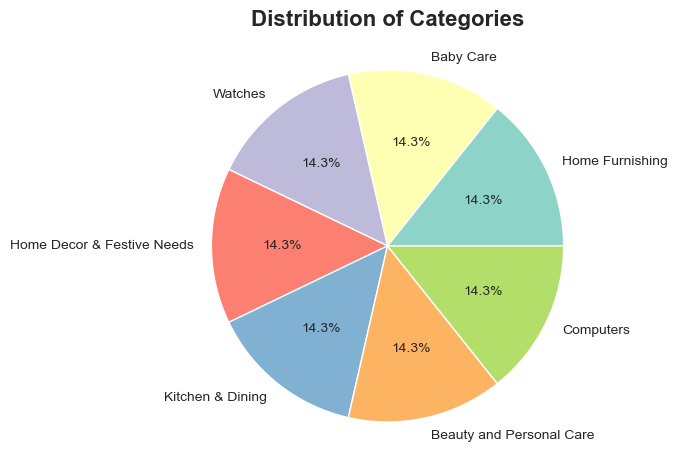

In [14]:
# La distribution par categorie
custom_colors = sns.color_palette('Set3', len(category_count))
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', colors=custom_colors)
plt.title('Distribution of Categories',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 

plt.show()

Il y a sept grandes catégories de produits

## Pre traitement

## Exploration des données


In [15]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wall

In [16]:
df_t = df 
df_t.shape

(1050, 16)

In [17]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

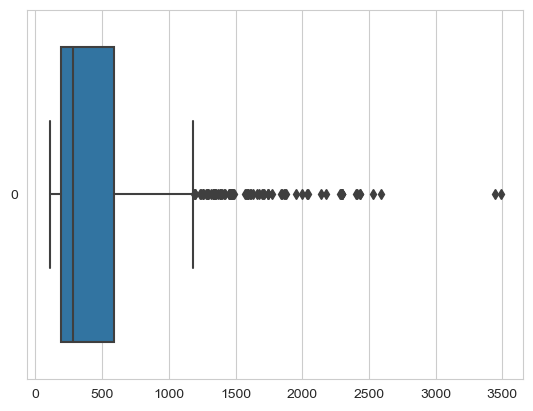

In [18]:
tmp = df.description.str.len()
sns.boxplot(tmp, orient='h');

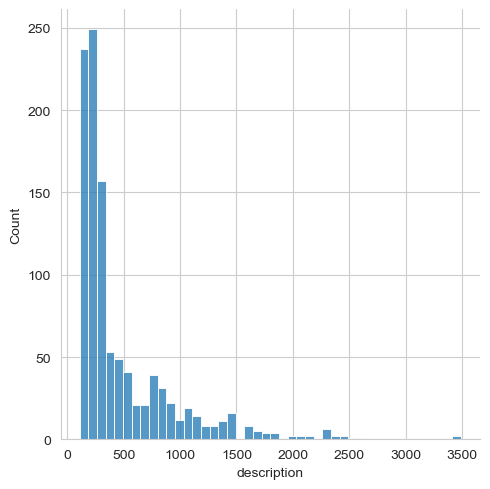

In [19]:
sns.displot(tmp);

In [20]:
df_long = df["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [21]:
df.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,275
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,268
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,817
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >

In [22]:
df_samp = df.sample(10)
df_samp

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
753,998a39dca0ef610c3a0ea4e9cc6e1681,2015-12-12 11:46:53 +0000,http://www.flipkart.com/tuktuk-abstract-single...,Tuktuk Abstract Single Dohar Black,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAE5YFQDXJESB3S,700.0,399.0,998a39dca0ef610c3a0ea4e9cc6e1681.jpg,False,Buy Tuktuk Abstract Single Dohar Black at Rs. ...,No rating available,No rating available,Tuktuk,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,122
802,020d2daba55a723128e4e07c0b0393a9,2015-12-12 11:46:53 +0000,http://www.flipkart.com/oxyglow-fruit-massage-...,Oxyglow Fruit Massage Cream With Vitamin-E & G...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEAHJXW4AFN4G7,1255.0,929.0,020d2daba55a723128e4e07c0b0393a9.jpg,False,Buy Oxyglow Fruit Massage Cream With Vitamin-E...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,251
664,c9c4720bca91b8ce27d8190a7c4c139c,2015-12-31 09:19:31 +0000,http://www.flipkart.com/blue-bell-popfun-sippe...,Blue Bell Popfun Sipper,"[""Baby Care >> Feeding & Nursing >> Utensils >...",SICDBJVHQ3DJRGM9,280.0,180.0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,False,Buy Blue Bell Popfun Sipper for Rs.180 online....,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Age Group""...",Baby Care,177
857,a41371b2f8859b015031f0d5eda5184c,2015-12-29 05:07:38 +0000,http://www.flipkart.com/99gems-smart-otg-conne...,99Gems Smart OTG Connection kit USB USB Cable,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEDSKFXUHKEGME,399.0,199.0,a41371b2f8859b015031f0d5eda5184c.jpg,False,99Gems Smart OTG Connection kit USB USB Cable ...,No rating available,No rating available,99Gems,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,673
651,705b90361aeda1849a728d80625a78a9,2015-12-31 09:19:31 +0000,http://www.flipkart.com/marvel-cotton-bath-tow...,Marvel Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEE4HMGWFQPGWH,449.0,449.0,705b90361aeda1849a728d80625a78a9.jpg,False,Buy Marvel Cotton Bath Towel at Rs. 449 at Fli...,No rating available,No rating available,Marvel,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,112
893,526cb1e7675adb39a1ea68f1f2a3fd59,2015-12-20 08:26:17 +0000,http://www.flipkart.com/durga-home-trendz-cott...,Durga Home Trendz Cotton Hand Towel,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWEDGMRHGQZKRZR,599.0,250.0,526cb1e7675adb39a1ea68f1f2a3fd59.jpg,False,Durga Home Trendz Cotton Hand Towel (Hand Towe...,No rating available,No rating available,Durga Home Trendz,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,224
939,b7e42b52534c5e49eb03817d754c2153,2016-01-01 13:15:34 +0000,http://www.flipkart.com/welhouse-geometric-dou...,Welhouse Geometric Double Blanket Grey,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAEEGTHFYHFFFUG,1699.0,1049.0,b7e42b52534c5e49eb03817d754c2153.jpg,False,Buy Welhouse Geometric Double Blanket Grey at ...,No rating available,No rating available,Welhouse,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,127
225,67d6b4a8aa19d57740b0440365b77624,2015-12-01 12:40:44 +0000,http://www.flipkart.com/lal-haveli-decorative-...,Lal Haveli Decorative Dholak Musician Showpiec...,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIEBCQZF8EQ3FSD,1450.0,1085.0,67d6b4a8aa19d57740b0440365b77624.jpg,False,Lal Haveli Decorative Dholak Musician Showpiec...,No rating available,No rating available,Lal Haveli,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,736
827,ad55b7ac6f7284b90d31a1a2f175df8d,2015-12-29 05:07:38 +0000,http://www.flipkart.com/mesleep-abstract-cushi...,meSleep Abstract Cushions Cover,"[""H

In [23]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: 998a39dca0ef610c3a0ea4e9cc6e1681
Buy Tuktuk Abstract Single Dohar Black at Rs. 399 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


: 020d2daba55a723128e4e07c0b0393a9
Buy Oxyglow Fruit Massage Cream With Vitamin-E & Gold Facial Kit for Rs.929 online. Oxyglow Fruit Massage Cream With Vitamin-E & Gold Facial Kit at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


: c9c4720bca91b8ce27d8190a7c4c139c
Buy Blue Bell Popfun Sipper for Rs.180 online. Blue Bell Popfun Sipper at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


: a41371b2f8859b015031f0d5eda5184c
99Gems Smart OTG Connection kit USB USB Cable (Black)
                         Price: Rs. 199
				
			Features: Works on microUSB smart phone devices On-To-Go Function (OTG) - Allows you to connect USB devices such as keyboard, mouse and USB flash drive to your OTG compatible phone or tablet

In [24]:
df_samp0 = df.sample(10)
df_samp0

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
759,e80e5151787eb21b0cca0d7dc3b0c338,2015-12-12 11:46:53 +0000,http://www.flipkart.com/fighter-figh-008-digit...,Fighter FIGH_008 Digital Watch - For Couple,"[""Watches >> Wrist Watches >> Fighter Wrist Wa...",WATEAFG4PYZHTC52,949.0,225.0,e80e5151787eb21b0cca0d7dc3b0c338.jpg,False,Fighter FIGH_008 Digital Watch - For Couple -...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,258
643,86a39f77de21aa9654e8ea03335244fc,2016-02-28 10:36:58 +0000,http://www.flipkart.com/intel-3-2-ghz-lga-1150...,Intel 3.2 GHz LGA 1150 3250 Processor,"[""Computers >> Computer Components >> Processo...",PSREGFZ8MXRM6FFQ,6100.0,4500.0,86a39f77de21aa9654e8ea03335244fc.jpg,False,Specifications of Intel 3.2 GHz LGA 1150 3250 ...,No rating available,No rating available,Intel,"{""product_specification""=>[{""key""=>""Sales Pack...",Computers,613
683,ead122f4b1da293eb2d719baf104dfc9,2015-12-31 09:19:31 +0000,http://www.flipkart.com/lotus-safe-sun-uv-scre...,Lotus Safe Sun UV Screen MatteGel - SPF 50 PA+++,"[""Beauty and Personal Care >> Body and Skin Ca...",SNRE53FVTK2FQAKU,395.0,320.0,ead122f4b1da293eb2d719baf104dfc9.jpg,False,Flipkart.com: Buy Lotus Safe Sun UV Screen Mat...,4.3,4.3,NaN,"{""product_specification""=>[{""key""=>""Quantity"",...",Beauty and Personal Care,200
1023,b7214d4c357e3f7acae72fcbe7d31afe,2016-03-03 06:06:42 +0000,http://www.flipkart.com/transcend-premium-memo...,Transcend Premium Memory DDR2 2 GB (1x2GB) PC ...,"[""Computers >> Computer Components >> RAMs >> ...",RAMEGFGCHMH8AN8W,2999.0,1248.0,b7214d4c357e3f7acae72fcbe7d31afe.jpg,False,Specifications of Transcend Premium Memory DDR...,4.2,4.2,Transcend,"{""product_specification""=>[{""key""=>""Sales Pack...",Computers,556
134,258444ac7bb7ad8026800efad5c3502b,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rajesh-digital-best-da...,Rajesh Digital BEST DAD 107 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Rajesh Di...",MUGE9ZVGGRKZBUUA,350.0,250.0,258444ac7bb7ad8026800efad5c3502b.jpg,False,Buy Rajesh Digital BEST DAD 107 Ceramic Mug fo...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",Kitchen & Dining,209
394,bd95002e0fea67f7ec2f2597814c5eaf,2015-12-01 06:13:00 +0000,http://www.flipkart.com/trendnet-tew-737hre/p/...,TRENDnet TEW-737HRE,"[""Computers >> Network Components >> Routers >...",RTRE3KKXMVHMRQ6C,4499.0,2849.0,bd95002e0fea67f7ec2f2597814c5eaf.jpg,False,Buy TRENDnet TEW-737HRE only for Rs. 2849 from...,No rating available,No rating available,TRENDnet,"{""product_specification""=>[{""key""=>""Wireless S...",Computers,146
869,d218c32df572e82db50faecd62179db2,2015-12-20 08:26:17 +0000,http://www.flipkart.com/homec-geometric-cushio...,Homec Geometric Cushions Cover,"[""Home Furnishing >> Cushions, Pillows & Cover...",CPCECFY5BYTYVSKE,1399.0,799.0,d218c32df572e82db50faecd62179db2.jpg,False,"Homec Geometric Cushions Cover (Pack of 10, 40...",No rating available,No rating available,Homec,"{""product_specification""=>[{""key""=>""Closure"", ...",Home Furnishing,257
74,7a3f11f380a1bf85338ab3771ff81e9f,2016-04-21 20:34:29 +0000,http://www.flipkart.com/vitamins-graphic-print...,Vitamins Graphic Print Baby Girl's Basic Shorts,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",SRTEHHXG8MUXTGPA,529.0,529.0,7a3f11f380a1bf85338ab3771ff81e9f.jpg,False,Key Features of Vitamins Graphic Print Baby Gi...,No rating available,No rating available,Vitamins,"{""product_specification""=>[{""key""=>""Ideal For""...",Baby Care,460
226,f39a2cce8929f5b44087d688995994e4,2015-12-01 12:40:44 +0000,http://www.flipkart.com/tiedribbons-love-mom-g...,Tiedribbons We Love Mom With Green Background ...,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIE6ZSBWP9DTDHZ,15

### Nettoyage de la fonctionalité "description"
### Bag of word

In [25]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [27]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [28]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

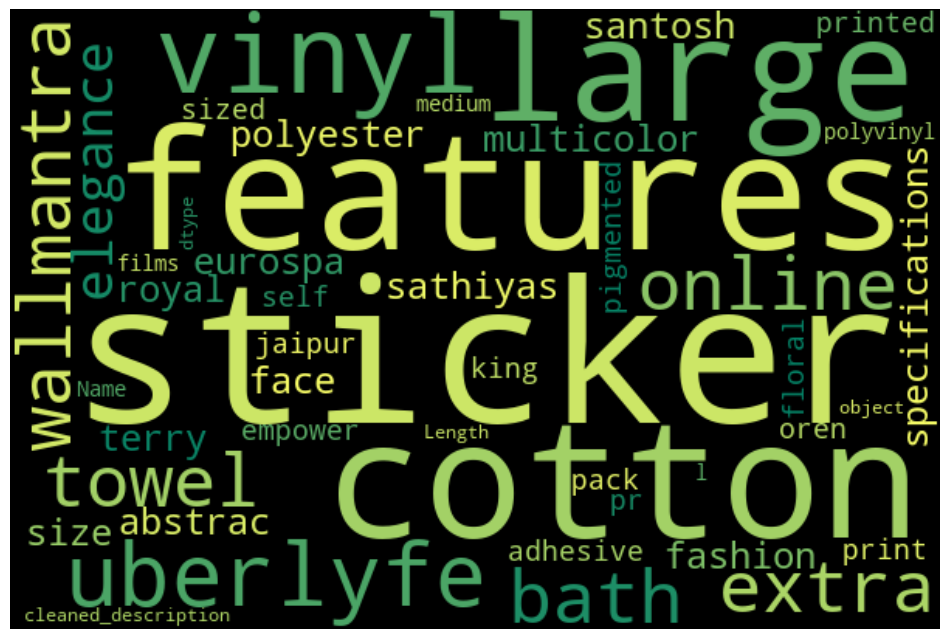

In [29]:
cloud=WordCloud(colormap="summer",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [30]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [31]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [32]:
df_t["tokenized"]

0       [features, elegance, polyester, multicolor, ab...
1       [specifications, sathiyas, cotton, bath, towel...
2       [features, eurospa, cotton, terry, face, towel...
3       [features, santosh, royal, fashion, cotton, pr...
4       [features, jaipur, print, cotton, floral, king...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, online, uber...
Name: tokenized, Length: 1050, dtype: object

### Lemmatization

In [33]:
from nltk.stem import WordNetLemmatizer 

In [34]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [35]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [36]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [37]:
df_t

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"[features, elegance, polyester, multicolor, ab...","[feature, elegance, polyester, multicolor, abs...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"[specifications, sathiyas, cotton, bath, towel...","[specifications, sathiyas, cotton, bath, towel...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"[features, eurospa, cotton, terry, face, towel...","[feature, eurospa, cotton, terry, face, towel,...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"[features, santosh, royal, fashion, cotton, pr...","[feature, santosh, royal, fashion, cotton, pri...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"[features, jaipur, print, cotton, floral, king...","[feature, jaipur, print, cotton, floral, king,...",feature jaipur print cotton floral king size d...,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2432,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive s

In [38]:
df_t.to_csv('df_t.csv', index=False)

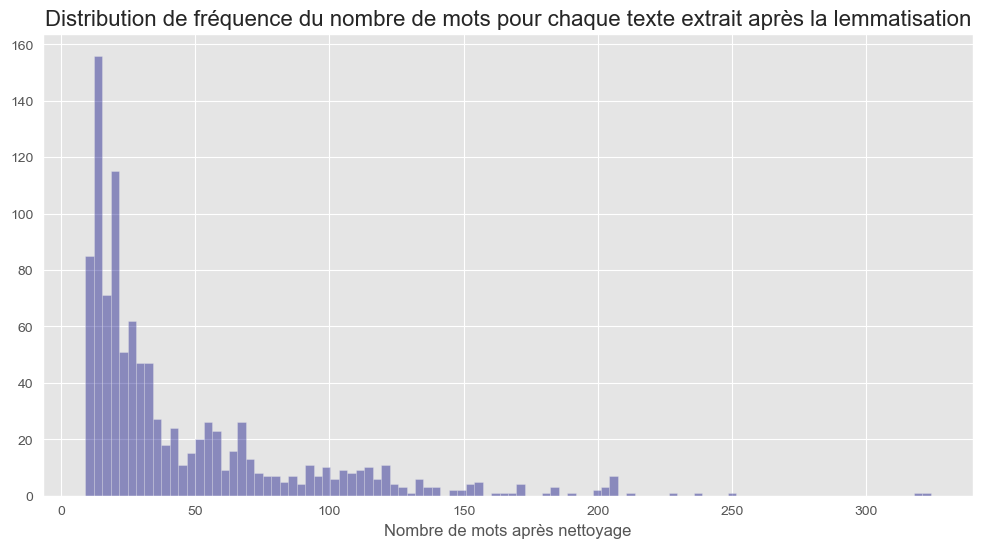

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [40]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

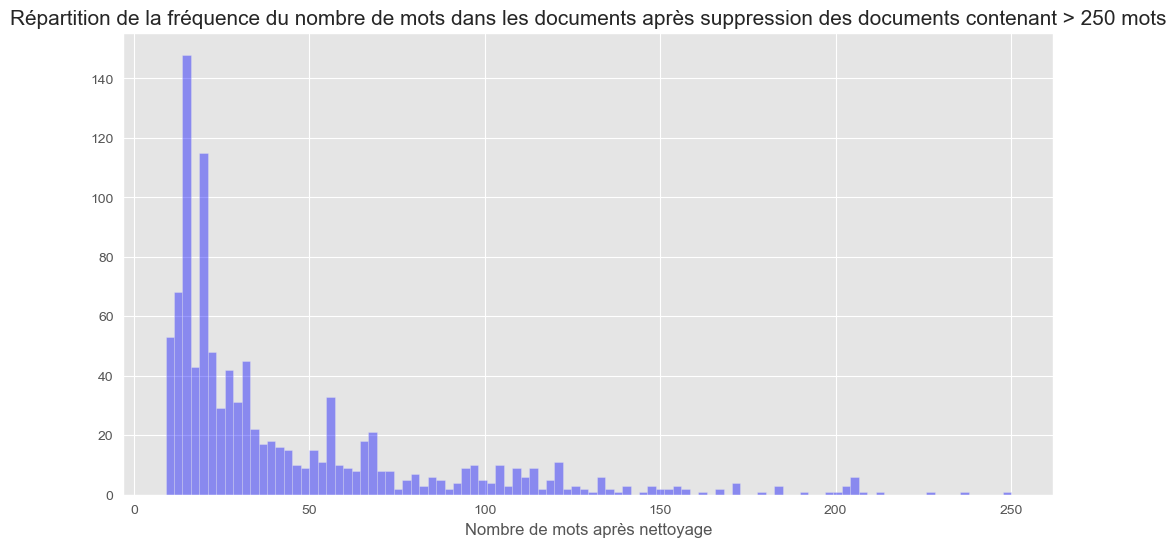

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

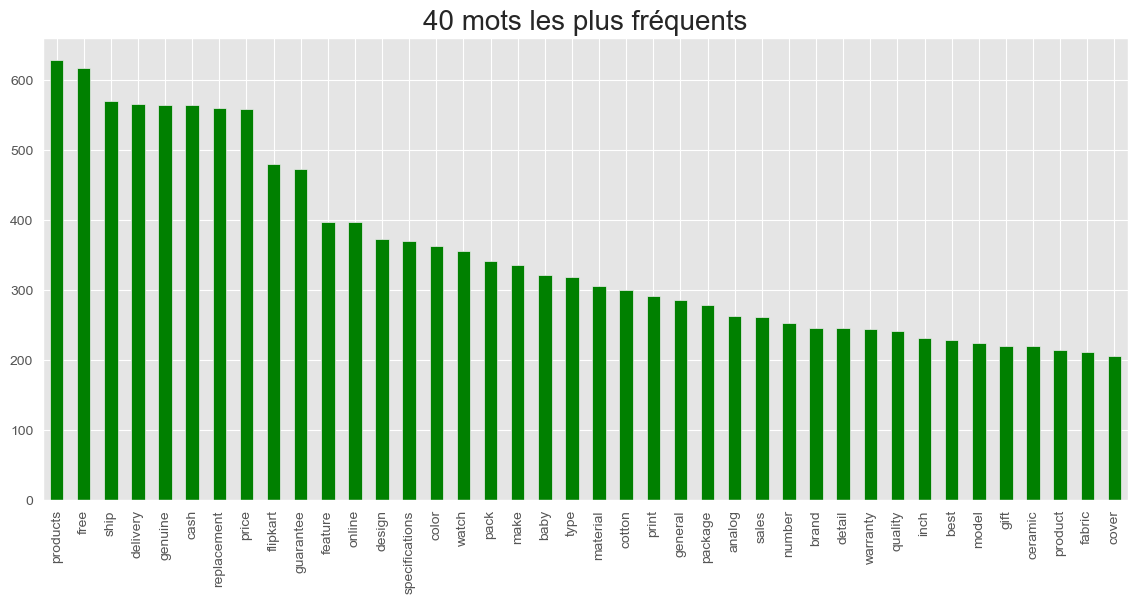

In [42]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:40]
freq.plot(kind="bar", color = "green")
plt.title("40 mots les plus fréquents",size=20);

## NLP   
### TF-IDF (Term frequency-inverse document frequency)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
import itertools
import tensorflow as tf


In [54]:
from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [55]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
        
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [56]:
tfidf = TfidfVectorizer()
 
# get tf-df values
result = tfidf.fit_transform(df_t["description"])

In [57]:
# display tf-idf values
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 3574)	0.02435118531699746
  (0, 2012)	0.028231536843717507
  (0, 1279)	0.03463120725266925
  (0, 4047)	0.047392208123346664
  (0, 4765)	0.047392208123346664
  (0, 1769)	0.027631362017021478
  (0, 3909)	0.02378080899306603
  (0, 1317)	0.0225107899230491
  (0, 3371)	0.034095824079673556
  (0, 2063)	0.027503127000571684
  (0, 1664)	0.02382345467055865
  (0, 2180)	0.06705250833395213
  (0, 3015)	0.0364533820607544
  (0, 4871)	0.026594252177580834
  (0, 3818)	0.031214911825098335
  (0, 3694)	0.05462810674834151
  (0, 5598)	0.02348768047602811
  (0, 2577)	0.011827470124136853
  (0, 2013)	0.0364533820607544
  (0, 1330)	0.024261108770697478
  (0, 2692)	0.0213290503952278
  (0, 5120)	0.019910474036639328
  (0, 5283)	0.06705250833395213
  (0, 916)	0.06065283792500038
  (0, 4661)	0.0484493666071762
  :	:
  (1047, 5603)	0.5643396287255084
  (1047, 5728)	0.400359677351323
  (1047, 5190)	0.400359677351323
  (1047, 3328)	0.42656889073766247
  (1047, 4353)	0.108132476015503
  (104

In [58]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df_t["lemmatize_joined"])
final_tf_idf.shape

(1048, 3986)

In [59]:
final_tf_idf

<1048x3986 sparse matrix of type '<class 'numpy.float64'>'
	with 29004 stored elements in Compressed Sparse Row format>

In [50]:
finalScore = df_t['category']
finalScore

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1048, dtype: object

In [64]:
# Dimensional reduction
from sklearn.decomposition import PCA

In [65]:
# Defining the PCA
n_components = 2
pca = PCA(n_components=n_components)

# Fitting to the df_tfidf
pca_result = pca.fit_transform(df_tfidf)

# New df for the results 
df_pca = pd.DataFrame(data=pca_result, columns=["PC{}".format(i+1) for i in range(n_components)])

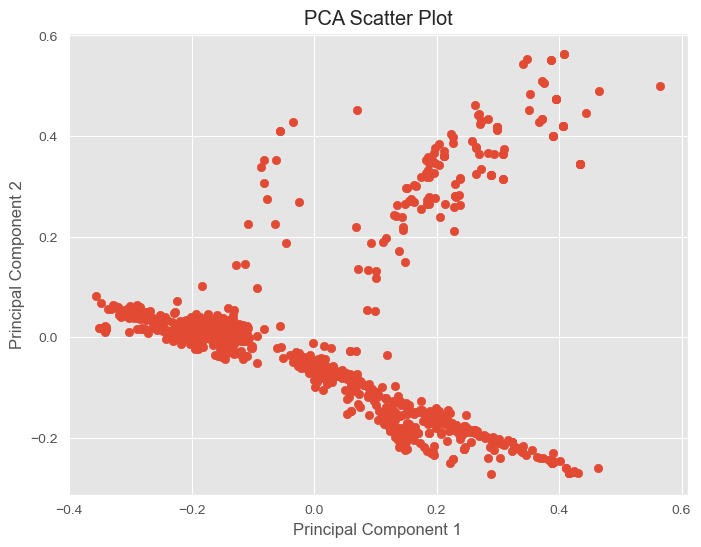

In [66]:
# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

### t-SNE visualization for TF-IDF

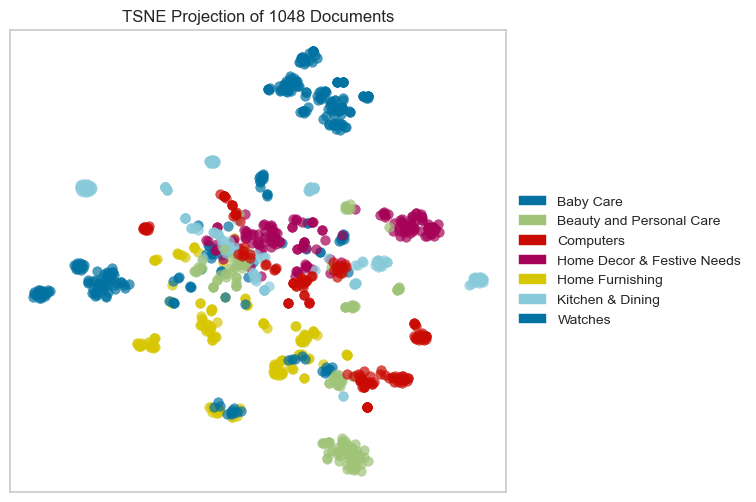

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = df_t.lemmatize_joined
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = df_t.category

# Create the visualizer and draw the vectors
plt.figure(figsize=(8, 6))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show();

In [69]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

text = df_t.lemmatize_joined

vec = TfidfVectorizer()
feat = vec.fit_transform(text)
kmeans = KMeans(7).fit(feat)
pred = kmeans.predict(feat)

In [70]:
print(pred)

[2 2 2 ... 1 1 1]


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus =df_t.lemmatize_joined

vectorizer = TfidfVectorizer() 
x = vectorizer.fit_transform(corpus)
final = pd.DataFrame(x.toarray(), columns =vectorizer.get_feature_names_out())
final

,aapno,aari,aarika,abide,abilities,ability,abkl,able,abroad,absolute,...,zero,zikrak,zinc,zingalalaa,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
